In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import numpy as np
import pandas as pd
import SimpleITK as sitk
from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
import math
from skimage.filters import threshold_mean
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage
from scipy import signal
import cv2
import math

CT Shape=(260, 311, 260)
CT Mask Shape=(260, 311, 260)


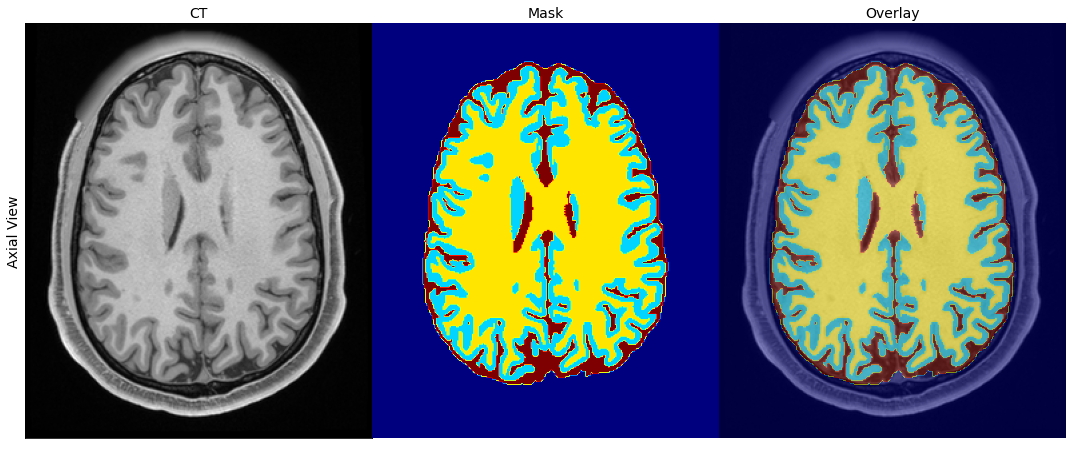

In [2]:
ct_path='/Users/yichengzou/Desktop/Yap Lab/adult_image_Yicheng/550439/T1w_acpc_dc_restore.nii.gz'
ct_label_path='/Users/yichengzou/Desktop/Yap Lab/adult_image_Yicheng/550439/tissue_map_relabeled_edited.nii.gz'

# CT
img_sitk  = sitk.ReadImage(ct_path, sitk.sitkFloat32) # Reading CT
image     = sitk.GetArrayFromImage(img_sitk) #Converting sitk_metadata to image Array
# Mask
mask_sitk = sitk.ReadImage(ct_label_path,sitk.sitkInt32) # Reading CT
mask      = sitk.GetArrayFromImage(mask_sitk)#Converting sitk_metadata to image Array

print('CT Shape={}'.format(image.shape))
print('CT Mask Shape={}'.format(mask.shape))

#----Lets plot 
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(image[150, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('CT',fontsize=14)

axarr[1].imshow(np.squeeze(mask[150, :, :]), cmap='jet',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('Mask',fontsize=14)

axarr[2].imshow(np.squeeze(image[150, :, :]), cmap='gray',alpha=1,origin='lower');
axarr[2].imshow(np.squeeze(mask[150, :, :]),cmap='jet',alpha=0.5,origin='lower');
axarr[2].axis('off')
axarr[2].set_title('Overlay',fontsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

In [3]:
def normalise(image):

    image = image.astype(np.float32)

    mid = np.median(image)
    image = np.abs(image-mid)
    mad = np.median(image)
    std = 1.4826*mad

    if std > 0:
        ret = (image - mad) / std
    else:
        ret = image * 0.
    return ret




norm_img=normalise(image)

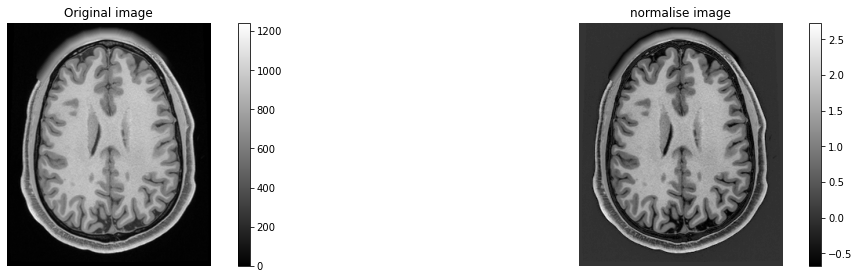

In [4]:
f, axarr = plt.subplots(1, 2, figsize=(20,5));

img = axarr[0].imshow(np.squeeze(image[150, :, :]), cmap='gray',origin='lower');
axarr[0].axis('off')
axarr[0].set_title('Original image')
f.colorbar(img, ax=axarr[0])


img = axarr[1].imshow(np.squeeze(norm_img[150, :, :]), cmap='gray',origin='lower');
axarr[1].axis('off')
axarr[1].set_title('normalise image')
f.colorbar(img, ax=axarr[1])

    
f.subplots_adjust(wspace=0.05, hspace=0, top=0.8)
plt.show();

In [6]:
inputImage = sitk.GetImageFromArray(norm_img)
maskImage = sitk.OtsuThreshold(inputImage,0,1,200)

inputImage = sitk.Cast(inputImage,sitk.sitkFloat32)

corrector = sitk.N4BiasFieldCorrectionImageFilter();

output_sitk = corrector.Execute(inputImage,maskImage)
output = sitk.GetArrayFromImage(output_sitk)

Text(0.5, 1.0, 'intensity correction')

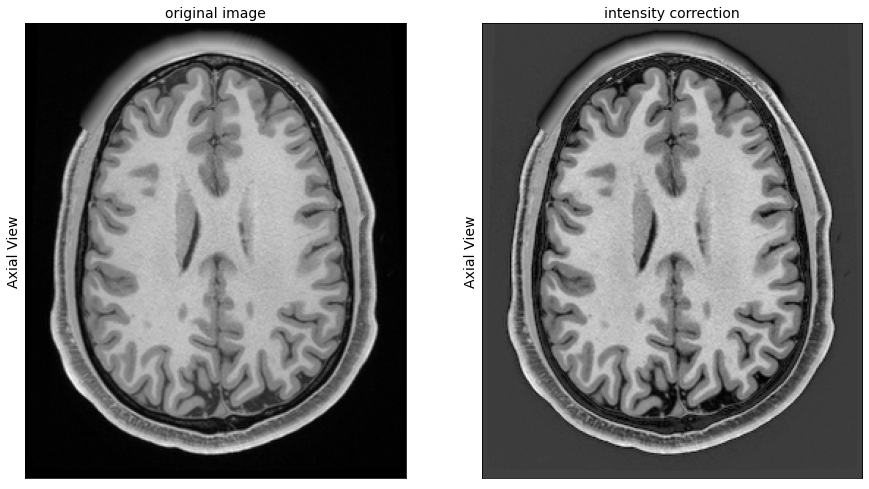

In [7]:
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(np.squeeze(image[150, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('original image',fontsize=14)

axarr[1].imshow(np.squeeze(output[150, :, :]), cmap='gray',origin='lower');
axarr[1].set_ylabel('Axial View',fontsize=14)
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[1].set_title('intensity correction',fontsize=14)

In [8]:
output.shape

(260, 311, 260)

In [9]:
mask.shape

(260, 311, 260)

In [10]:
csf = np.zeros_like(mask, dtype=np.float32)
csf[np.where(mask == 3)] = 1

wm = np.zeros_like(mask, dtype=np.float32)
wm[np.where(mask == 2)] = 1

gm = np.zeros_like(mask, dtype=np.float32)
gm[np.where(mask == 1)] = 1


Text(0.5, 1.0, 'gm')

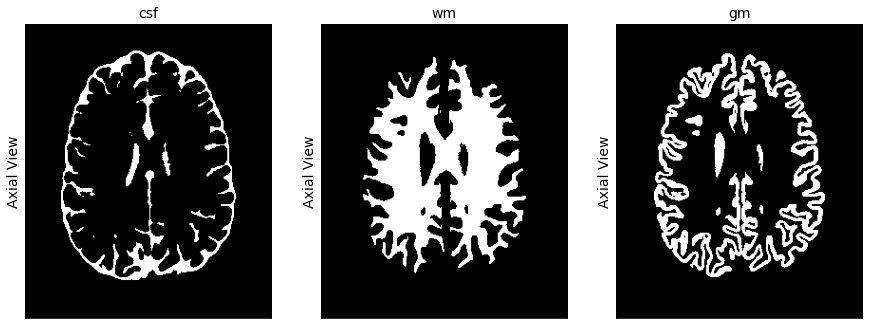

In [20]:
f, axarr = plt.subplots(1,3,figsize=(15,15))
axarr[0].imshow(np.squeeze(csf[150, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('csf',fontsize=14)

axarr[1].imshow(np.squeeze(wm[150, :, :]), cmap='gray',origin='lower');
axarr[1].set_ylabel('Axial View',fontsize=14)
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[1].set_title('wm',fontsize=14)

axarr[2].imshow(np.squeeze(gm[150, :, :]), cmap='gray',origin='lower');
axarr[2].set_ylabel('Axial View',fontsize=14)
axarr[2].set_xticks([])
axarr[2].set_yticks([])
axarr[2].set_title('gm',fontsize=14)

In [42]:
np.mean(output)

0.29269472

In [38]:
lower_threshold = np.mean(gm)+np.std(gm)/2
lower_threshold

-0.05049414932727814

In [39]:
upper_threshold = np.mean(wm)-np.std(wm)/2
upper_threshold

0.22630979865789413

In [40]:
binary = np.ones_like(output, dtype=np.float32)
binary[np.where(output>lower_threshold)] = 0
binary[np.where(output<upper_threshold)] = 0

Text(0.5, 1.0, 'binary image')

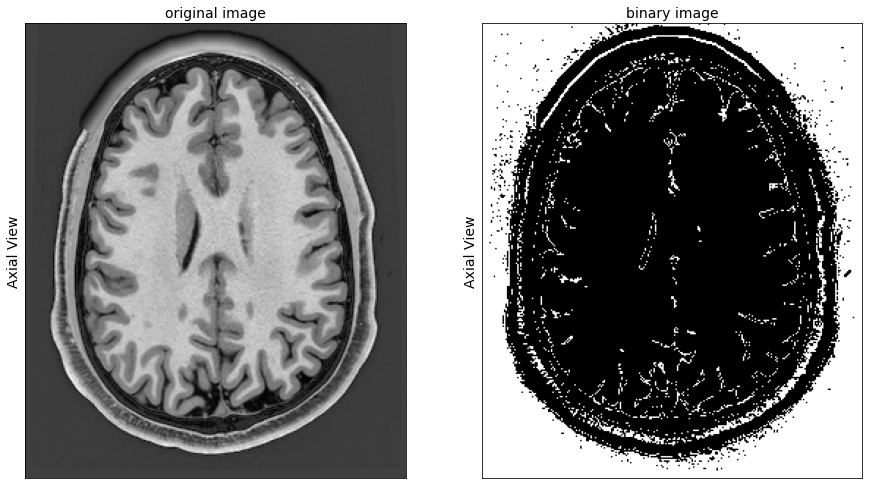

In [41]:
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(np.squeeze(output[150, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('original image',fontsize=14)

axarr[1].imshow(np.squeeze(binary[150, :, :]), cmap='gray',origin='lower');
axarr[1].set_ylabel('Axial View',fontsize=14)
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[1].set_title('binary image',fontsize=14)

In [33]:
array = np.ones([125,1])
conv_kernel = array.reshape(5,5,5)
conv_kernel.shape

(5, 5, 5)

In [34]:
def checkShape(var, kernel):
    '''Check shapes for convolution

    Args:
        var (ndarray): 2d or 3d input array for convolution.
        kernel (ndarray): 2d or 3d convolution kernel.
    Returns:
        kernel (ndarray): 2d kernel reshape into 3d if needed.
    '''
    var_ndim = np.ndim(var)
    kernel_ndim = np.ndim(kernel)

    if var_ndim not in [2, 3]:
        raise Exception("<var> dimension should be in 2 or 3.")
    if kernel_ndim not in [2, 3]:
        raise Exception("<kernel> dimension should be in 2 or 3.")
    if var_ndim < kernel_ndim:
        raise Exception("<kernel> dimension > <var>.")
    if var_ndim == 3 and kernel_ndim == 2:
        kernel = np.repeat(kernel[:, :, None], var.shape[2], axis=2)

    return kernel

def pickStrided(var, stride):
    '''Pick sub-array by stride

    Args:
        var (ndarray): 2d or 3d ndarray.
        stride (int): stride/step along the 1st 2 dimensions to pick
            elements from <var>.
    Returns:
        result (ndarray): 2d or 3d ndarray picked at <stride> from <var>.
    '''
    if stride < 0:
        raise Exception("<stride> should be >=1.")
    if stride == 1:
        result = var
    else:
        result = var[::stride, ::stride, ...]
    return result

def conv3D(var, kernel, stride=1, pad=0):
    '''3D convolution using scipy.signal.fftconvolve.

    Args:
        var (ndarray): 2d or 3d array to convolve along the first 2 dimensions.
        kernel (ndarray): 2d or 3d kernel to convolve. If <var> is 3d and <kernel>
        is 2d, create a dummy dimension to be the 3rd dimension in kernel.
    Keyword Args:
        stride (int): stride along the 1st 2 dimensions. Default to 1.
        pad (int): number of columns/rows to pad at edges.
    Returns:
        conv (ndarray): convolution result.
    '''
    stride = int(stride)
    kernel = checkShape(var, kernel)
    if pad > 0:
        var_pad = padArray(var, pad, pad)
    else:
        var_pad = var

    conv = signal.fftconvolve(var_pad, kernel, mode='valid')
    if stride > 1:
        conv = pickStrided(conv, stride)

    return conv

In [35]:
conv = conv3D(binary, conv_kernel)

Text(0.5, 1.0, 'conv image')

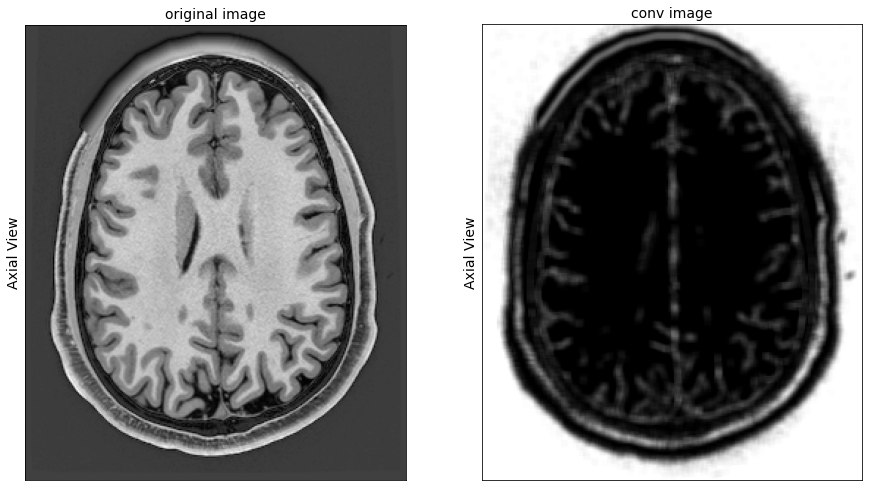

In [36]:
f, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].imshow(np.squeeze(output[150, :, :]), cmap='gray',origin='lower');
axarr[0].set_ylabel('Axial View',fontsize=14)
axarr[0].set_xticks([])
axarr[0].set_yticks([])
axarr[0].set_title('original image',fontsize=14)

axarr[1].imshow(np.squeeze(conv[150, :, :]), cmap='gray',origin='lower');
axarr[1].set_ylabel('Axial View',fontsize=14)
axarr[1].set_xticks([])
axarr[1].set_yticks([])
axarr[1].set_title('conv image',fontsize=14)